# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0+cu101


# Preparing Training and Test Sets

In [ ]:
import zipfile

zip_file = '/content/drive/My Drive/ML project/deep learning /DetectingCOVID-19_Chest X-Ray/archive.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content/drive/My Drive/ML project/deep learning /DetectingCOVID-19_Chest X-Ray/DetectingCOVID-19_ChestX-Ray')

In [ ]:
File_dir = '/content/drive/My Drive/ML project/deep learning /DetectingCOVID-19_Chest X-Ray/DetectingCOVID-19_ChestX-Ray/COVID-19 Radiography Database'
class_names = ['normal', 'viral', 'covid']
class_dir = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(File_dir, class_dir[1])):
    os.mkdir(os.path.join(File_dir, 'test'))

    for i, d in enumerate(class_dir):
        os.rename(os.path.join(File_dir, d), os.path.join(File_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(File_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(File_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 64)
        for image in selected_images:
            source_path = os.path.join(File_dir, c, image)
            target_path = os.path.join(File_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
file_dir = '/content/drive/My Drive/ML project/deep learning /DetectingCOVID-19_Chest X-Ray/DetectingCOVID-19_ChestX-Ray/COVID-19 Radiography Database'

In [6]:
train_dirs = {
    'normal': os.path.join(file_dir,'train/normal'),
    'viral': os.path.join(file_dir,'train/viral'),
    'covid': os.path.join(file_dir,'train/covid')}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1277 normal examples
Found 1281 viral examples
Found 155 covid examples


In [7]:
test_dirs = {
    'normal': os.path.join(file_dir,'test/normal'),
    'viral': os.path.join(file_dir,'test/viral'),
    'covid': os.path.join(file_dir,'test/covid')}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 64 normal examples
Found 64 viral examples
Found 64 covid examples


In [29]:
batch_size = 32

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 85
Number of test batches 6


# Data Visualization

In [42]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
  
  plt.figure(figsize=(12, 6))
  for i, image in enumerate(images):
      plt.subplot(6, 6, i + 1, xticks=[], yticks=[])
      image = image.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = image * std + mean
      image = np.clip(image, 0., 1.)
      plt.imshow(image)
      col = 'green'
      labels.cpu().numpy()
      if preds[i] != labels[i]:
          col = 'red'
          
      plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
      plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
  plt.tight_layout()
  plt.show()

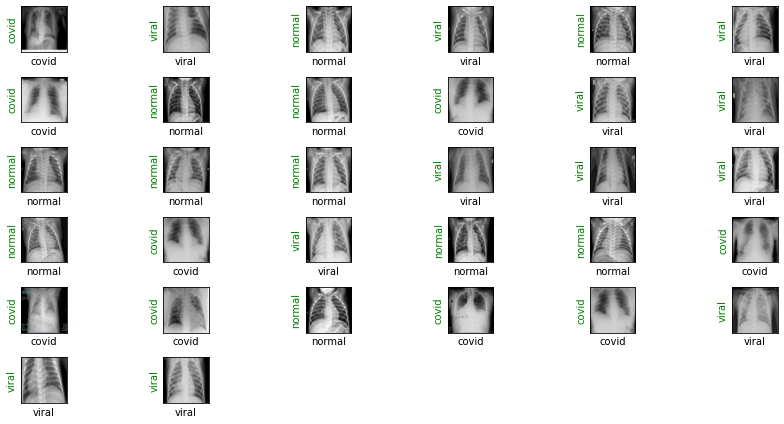

In [43]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

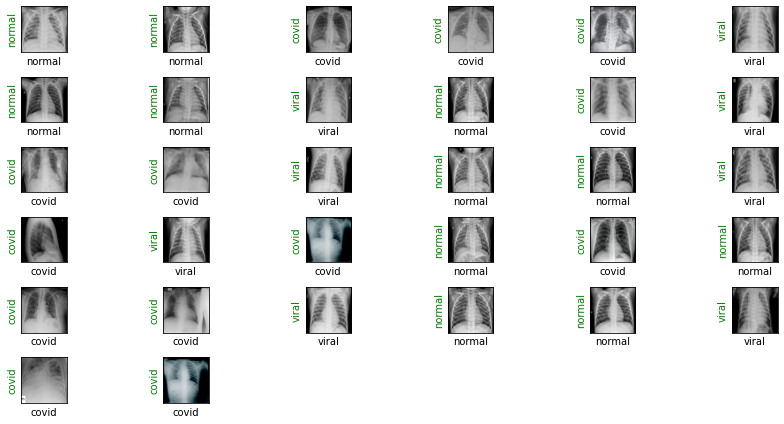

In [44]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [48]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [51]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

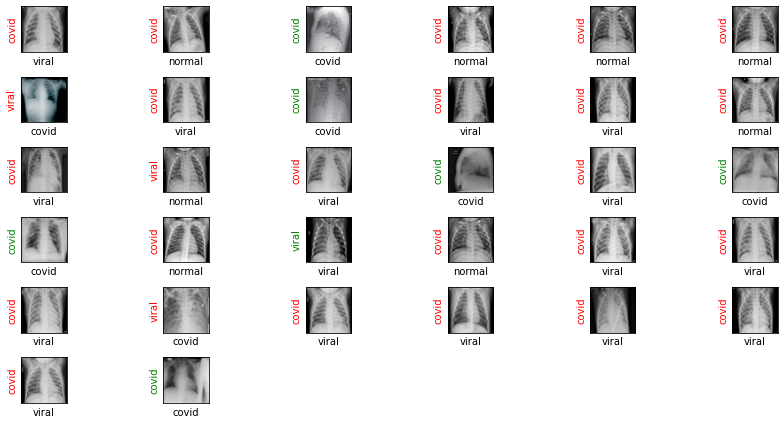

In [52]:
show_preds()

# Training the Model

In [55]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                #show_preds()

                resnet18.train()

                if accuracy >= 0.99:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [56]:
%%time

train(epochs=10)

Starting training..
Starting epoch 1/10
Evaluating at step 0
Validation Loss: 1.1698, Accuracy: 0.3438
Evaluating at step 20
Validation Loss: 0.5779, Accuracy: 0.9062
Evaluating at step 40
Validation Loss: 0.3797, Accuracy: 0.9115
Evaluating at step 60
Validation Loss: 0.2732, Accuracy: 0.9479
Evaluating at step 80
Validation Loss: 0.2515, Accuracy: 0.9427
Training Loss: 0.2566
Starting epoch 2/10
Evaluating at step 0
Validation Loss: 0.1966, Accuracy: 0.9427
Evaluating at step 20
Validation Loss: 0.2224, Accuracy: 0.9427


KeyboardInterrupt: ignored

# Final Results

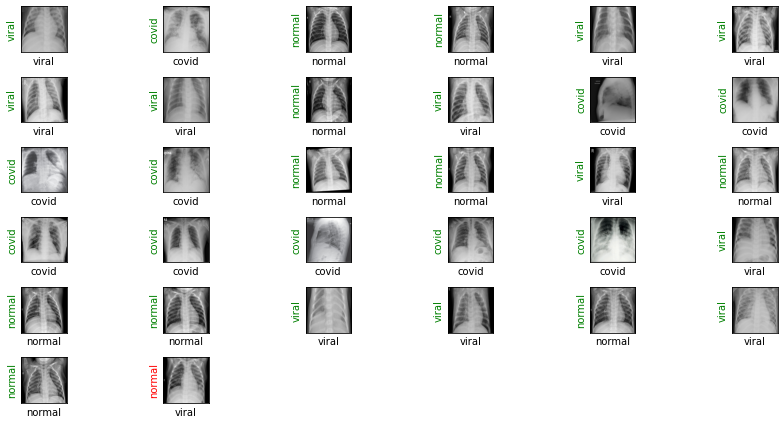

In [57]:
show_preds()